In [1]:
# notice - not exporting this to ptp lib

# Modeling

> This is the Deep, Recurrent Survival Analysis part.

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from drsa.functions import event_time_loss, event_rate_loss
from drsa.model import DRSA

from pull_the_pitcher.data import processing, pipeline
from pull_the_pitcher.data.pipeline import add_targets
from pull_the_pitcher.metrics import preds_histogram, print_all_metrics
from pull_the_pitcher.utils import get_starts, front_pad, PTPDataset, save_model, load_model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Preparing processed csv data for Dataset class

In [3]:
train = pd.read_csv("../data/processed/train_2017_2018_2016.csv")
val = pd.read_csv("../data/processed/val_2017_2018_2016.csv")
test = pd.read_csv("../data/processed/test_2019.csv")
data = {"train": train,
        "val": val,
        "test": test}

with open("../data/processed/mappers_2017_2018_2016_2019.pkl", "rb") as f:
    mappers = pickle.load(f)
    
with open("../data/processed/scaler_2017_2018_2016_2019.pkl", "rb") as f:
    scaler = pickle.load(f)

In [4]:
# scaling test data (as tuned on training data)
data["test"][pipeline.feature_cols] = scaler.transform(data["test"][pipeline.feature_cols])

# replacing pitcher id with index of associated embedding
data["test"]["pitcher"] = [mappers["pitcher"].get(pitcher, 0) for pitcher in data["test"]["pitcher"]]

In [5]:
# quick dropping of a few unneeded columns
cols_to_drop = ['game_type', 'pitcher_team_year']
for dataset in data.values():
    dataset = dataset.drop(columns=cols_to_drop)

cols = pipeline.cols
for c in cols_to_drop:
    cols.remove(c)

In [7]:
padded_starts = {}
for set_, dataset in data.items():
    starts = get_starts(dataset, cols=cols, y_col="pulled")
    starts = add_targets(starts)
    padded_starts[set_] = front_pad(starts)

## Feeding processed data into torch `Dataset` class

In [8]:
# instantiating datasets
datasets = {}
for set_, starts in padded_starts.items():
    datasets[set_] = PTPDataset(starts)

# instantiating data loaders
dataloaders = {}
for set_, dataset in datasets.items():
    dataloaders[set_] = DataLoader(dataset, batch_size=256)

## Modeling

In [9]:
def val_metrics(model, valid_dl, alpha):
    model.eval()
    total = 0
    sum_evt_loss = 0
    sum_evr_loss = 0
    sum_loss = 0
    correct = 0
    for X, y in valid_dl:
        # housekeeping
        batch = y.shape[0]
        
        # calculating losses
        pred = model(X)
        # loss = F.binary_cross_entropy_with_logits(pred, y)
        evt_loss = event_time_loss(pred)
        evr_loss = event_rate_loss(pred)
        loss = (alpha*evt_loss) + ((1-alpha)*evr_loss)
        
        # updating running sums
        sum_evt_loss += batch*evt_loss.item()
        sum_evr_loss += batch*evr_loss.item()
        sum_loss += batch*(loss.item())
        total += y.shape[0]
        
    val_evt_loss = sum_evt_loss/total
    val_evr_loss = sum_evr_loss/total
    val_loss = sum_loss/total
    return val_evt_loss, val_evr_loss, val_loss 

In [10]:
def train_epocs(model, optimizer, train_dl, valid_dl, alpha=0.1, epochs=10, print_every=5):
    prev_val_loss = 1.5
    idx = 0
    evt_losses, evr_losses, losses = [], [], []
    for i in range(epochs):
        sum_loss = 0
        total = 0
        model.train()
        for X, y in train_dl:
            # housekeeping
            batch_size = y.shape[0]
            optimizer.zero_grad()
            
            # updating weights
            pred = model(X)
            evt_loss = event_time_loss(pred)
            evr_loss = event_rate_loss(pred)
            loss = (alpha*evt_loss) + ((1-alpha)*evr_loss)
            loss.backward()
            optimizer.step()
            
            # calculating loss
            sum_loss += batch_size * loss.item()
            total += y.shape[1]
            idx += 1
                
        # updating loss
        train_loss = sum_loss/total
        val_evt_loss, val_evr_loss, val_loss = val_metrics(model, valid_dl, alpha)
        losses.append(val_loss); evt_losses.append(val_evt_loss); evr_losses.append(val_evr_loss)
        
        if i % print_every == 0:
            print(f"epoch {i} train evt_loss: {round(evt_loss.item(), 4)} train evr_loss: {round(evr_loss.item(), 4)}, train loss: {round(loss.item(), 4)}")
            print(f"epoch {i} valid evt_loss: {round(val_evt_loss, 4)} valid evr_loss: {round(val_evr_loss, 4)}, valid train loss: {round(val_loss, 4)}", end="\n\n")
    plt.plot(losses, label="total loss")
    plt.plot(evt_losses, label="evt loss")
    plt.plot(evr_losses, label="evr loss")
    plt.legend()
    plt.show()

In [11]:
# getting embeddings ready
n_pitchers = 270
pitcher_emb_size = 20
pitcher_embeddings = nn.Embedding(n_pitchers, pitcher_emb_size)
ptp_embeddings = [pitcher_embeddings]

# initializing model
drsa = DRSA(n_features=17,
            hidden_dim=20,
            n_layers=5,
            embeddings=ptp_embeddings,
            output_size=1,
            LSTM_dropout=0.05,
            Linear_dropout=0.1)

# initializing optimizer
optimizer = torch.optim.Adam(drsa.parameters(), lr=1e-3, weight_decay=1e-5)

In [12]:
# checking num params
total_params = sum([p[1].view(-1, 1).shape[0] for p in drsa.named_parameters()])
print(f"Number of total parameters: {total_params}")

Number of total parameters: 23501


epoch 0 train evt_loss: 21.0196 train evr_loss: -0.0, train loss: 18.9177
epoch 0 valid evt_loss: 19.5305 valid evr_loss: 0.0, valid train loss: 17.5775

epoch 5 train evt_loss: 7.0507 train evr_loss: 0.0409, train loss: 6.3497
epoch 5 valid evt_loss: 5.0649 valid evr_loss: 0.1461, valid train loss: 4.573

epoch 10 train evt_loss: 6.5323 train evr_loss: 0.0561, train loss: 5.8847
epoch 10 valid evt_loss: 4.6731 valid evr_loss: 0.2426, valid train loss: 4.2301

epoch 15 train evt_loss: 3.9191 train evr_loss: 0.0695, train loss: 3.5341
epoch 15 valid evt_loss: 3.2732 valid evr_loss: 0.7835, valid train loss: 3.0242



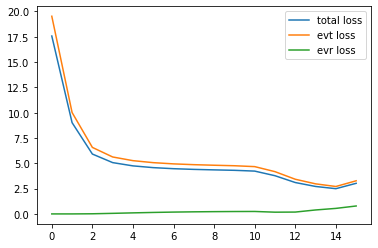

In [13]:
# training model
train_epocs(drsa, optimizer, dataloaders["train"], dataloaders["val"], alpha=0.9, epochs=16, print_every=5)

**Training notes**:
* Seems to be very touchy with dropout. Even applying a little bit on the linear layer makes it very difficult to learn.
    - 
* batch size of 128 seems to be best
* adding more layers inside of the lstm cell seems to help
    - big jump when I went from 2-5 layers

In [18]:
! ls ../models

06-17-20_DRSA_2017_2018_2019_loss_0.084.pth
06-17-20_DRSA_2017_2018_2019_loss_1.7337.pth
07-07-20_DRSA_2017_2018_2019_loss_0.3017.pth
07-10-20_DRSA_2016_2017_2018_2019_loss_2.6303.pth
07-15-20_DRSA_2016_2017_2018_2019_loss_2.9833.pth
07-15-20_LSTM_2016_2017_2018_2019_loss_0.3965.pth
07-22-20_DRSA_2016_2017_2018_2019_loss_2.6064.pth
07-22-20_DRSA_2016_2017_2018_2019_loss_2.6398.pth
07-22-20_DRSA_2016_2017_2018_2019_loss_3.749.pth
07-22-20_DRSA_2016_2017_2018_2019_loss_4.0985.pth
07-22-20_embeddings_2016_2017_2018_2019_loss_2.6064.pth
07-23-20_DRSA_2016_2017_2018_2019_loss_3.9734.pth


In [19]:
# loading up saved model
load_model(drsa, f"../models/07-22-20_DRSA_2016_2017_2018_2019_loss_4.0985.pth")
drsa.eval()

# organizing preds in df
dfs = {}
for set_, starts in padded_starts.items():
    features = np.concatenate(starts, axis=0)
    preds = []
    for X, y in dataloaders[set_]:
        pred = drsa(X).squeeze(0).detach().numpy().reshape(-1, 1)
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    dfs[set_] = pd.DataFrame(np.hstack([features, preds]), columns=cols+["last_batter", "pred"])

# getting rid of predictions for embeddings which do not occur in training set
dfs["test"] = dfs["test"].loc[(dfs["test"]["pitcher"]!=0)]


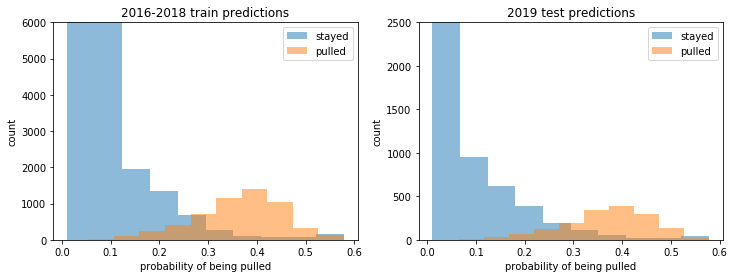

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
preds_histogram(dfs["train"]["last_batter"], dfs["train"]["pred"], ax=ax[0], ylim = (0, 6000), title="2016-2018 train predictions")
preds_histogram(dfs["test"]["last_batter"], dfs["test"]["pred"], ax=ax[1], ylim=(0, 2500), title="2019 test predictions")

In [21]:
# saving model
# save_model(drsa, f"../models/07-22-20_DRSA_2016_2017_2018_2019_loss_4.0985.pth")

## model evaluation

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     36447
         1.0       0.85      0.80      0.82      1616

    accuracy                           0.99     38063
   macro avg       0.92      0.90      0.91     38063
weighted avg       0.98      0.99      0.99     38063

mean plate appearance diff: 0.0
mean target diff: 0.00955


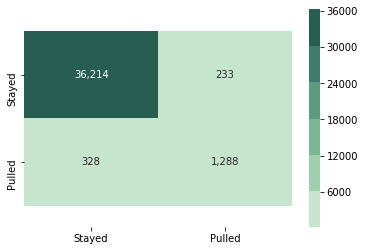

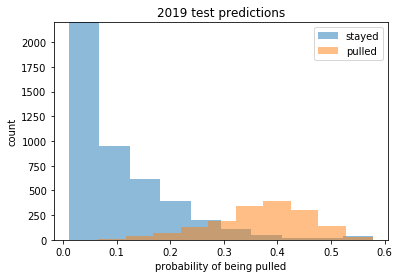

In [23]:
print_all_metrics(dfs["test"]["last_batter"], dfs["test"]["pred"], thresh=0.3)